In [1]:
import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import zarr
import warnings
from mpl_toolkits import mplot3d
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from re import split
from matplotlib.animation import ArtistAnimation
warnings.filterwarnings('ignore')
sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import time_3d, get_pars_from_ini
location = split(', |_|-|!', os.popen('hostname').read())[0]
path_data = get_pars_from_ini(campaign='loc')[location]['path_data']

plt.rcParams['animation.html'] = 'jshtml'
%matplotlib inline

In [10]:
ds_xr = xr.open_zarr(f'{path_data}/zarr/KUsKAs_Wn/lores.zarr')
df_xr = pd.DataFrame(data=ds_xr.time.values, columns=['date'])
df_times = pd.read_csv(f"{get_pars_from_ini(campaign='loc')[location]['path_proj']}/src/events.txt", 
                       header=None, parse_dates=[0], names=['date'])
merged = pd.merge(df_times, df_xr, on='date',how='right')
len(merged)

89835

In [3]:
def lee_filter(img, size, tresh=-150):
    img = np.where(np.logical_or(np.isnan(img), np.equal(img, -np.inf)),  tresh, img)
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2
    overall_variance = variance(img)
    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    img_output = np.where(img_output < 0, np.nan, img_output)
    return img_output


(0.0, 8000.0)

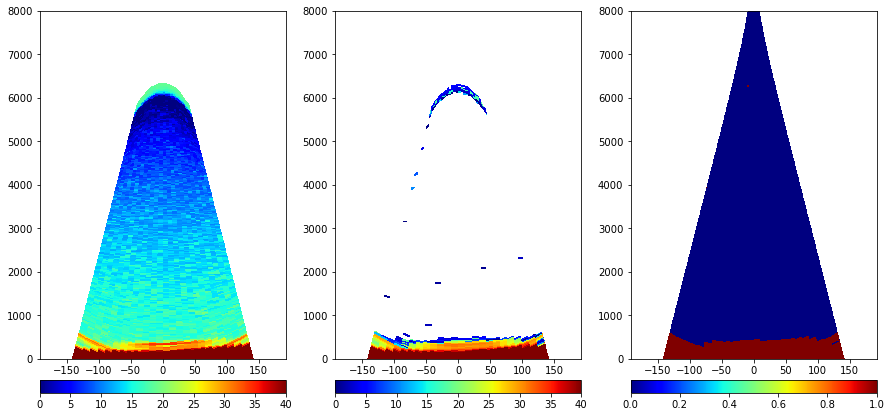

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))
artist = []

for index, row in merged[:50].iterrows():
    case = ds_xr.sel(time=row[0])
    filtered = lee_filter(case.zhh14.values, size=3, tresh=-180)
    x = case.range * np.sin(np.deg2rad(case.azimuth))
    y = case.alt3D * np.cos(np.deg2rad(case.azimuth))
    im1 = ax1.pcolormesh(x, y, case.zhh14, cmap='jet', vmin=0, vmax=40)
    im2 = ax2.pcolormesh(x, y, filtered, 
                         cmap='jet',  vmin=0, vmax=40)
    im3 = ax3.pcolormesh(x, y, (filtered > 0).astype(int), cmap='jet')
    artist.append([im1, im2, im3])
plt.colorbar(im1, ax=ax1, orientation="horizontal", pad=0.05)
plt.colorbar(im2, ax=ax2, orientation="horizontal", pad=0.05)
plt.colorbar(im3, ax=ax3, orientation="horizontal", pad=0.05)

ax1.set_ylim(0, 8000)
ax2.set_ylim(0, 8000)
ax3.set_ylim(0, 8000)


In [12]:
anim = ArtistAnimation(fig, artist, interval=100, blit=True)
anim

(0.0, 8000.0)

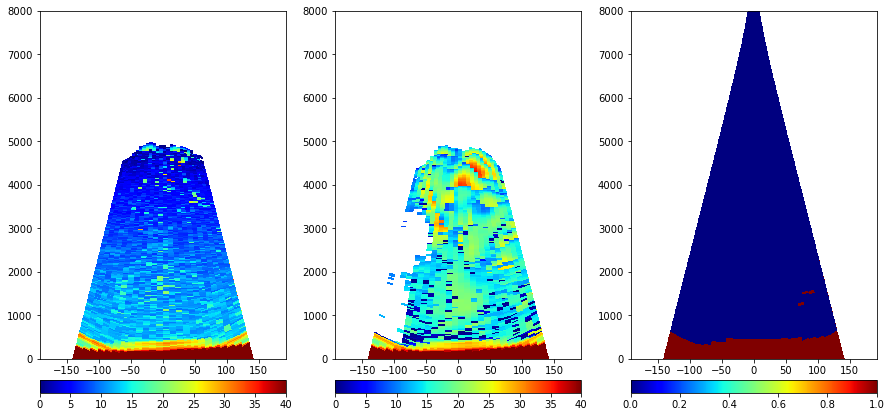

In [15]:
ds_xr = ds_xr.sel(time=~ds_xr.get_index("time").duplicated())
ds_dates = ds_xr.sel(time=slice('2019-09-16 03:12:40', '2019-09-16 03:13:40'))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))
artist = []

for _time in ds_dates.time:
    case = ds_xr.sel(time=_time)
    filtered = lee_filter(case.zhh14.values, size=3, tresh=-180)
    x = case.range * np.sin(np.deg2rad(case.azimuth))
    y = case.alt3D * np.cos(np.deg2rad(case.azimuth))
    im1 = ax1.pcolormesh(x, y, case.zhh14, cmap='jet', vmin=0, vmax=40)
    im2 = ax2.pcolormesh(x, y, filtered, 
                         cmap='jet',  vmin=0, vmax=40)
    im3 = ax3.pcolormesh(x, y, (filtered > 0).astype(int), cmap='jet')
    artist.append([im1, im2, im3])
plt.colorbar(im1, ax=ax1, orientation="horizontal", pad=0.05)
plt.colorbar(im2, ax=ax2, orientation="horizontal", pad=0.05)
plt.colorbar(im3, ax=ax3, orientation="horizontal", pad=0.05)

ax1.set_ylim(0, 8000)
ax2.set_ylim(0, 8000)
ax3.set_ylim(0, 8000)

In [16]:
anim = ArtistAnimation(fig, artist, interval=100, blit=True)
anim